## Exercise 1: Exoplanet Transit Timing

You're analyzing data from the **TESS** space telescope for the hot Jupiter **WASP-12b**. This tidally locked planet orbits dangerously close to its host star, completing one orbit every 1.09 days. The transit—when the planet passes in front of the star—causes a characteristic dip in the star's brightness.

### The Physics

During a transit, the observed flux follows:
$$F(t) = F_0 \left[1 - \text{depth} \times \text{transit_function}(t)\right]$$

For a circular planetary disk crossing a uniform stellar disk, the transit function is:
$$\text{transit_function}(t) = \begin{cases}
0 & \text{if } t < t_0 - T_{\text{total}}/2 \text{ or } t > t_0 + T_{\text{total}}/2 \\
\frac{t - (t_0 - T_{\text{total}}/2)}{(T_{\text{total}} - T_{\text{flat}})/2} & \text{if } t_0 - T_{\text{total}}/2 \leq t \leq t_0 - T_{\text{flat}}/2 \\
1 & \text{if } t_0 - T_{\text{flat}}/2 < t < t_0 + T_{\text{flat}}/2 \\
\frac{(t_0 + T_{\text{total}}/2) - t}{(T_{\text{total}} - T_{\text{flat}})/2} & \text{if } t_0 + T_{\text{flat}}/2 \leq t \leq t_0 + T_{\text{total}}/2
\end{cases}$$

This gives a trapezoidal transit profile with linear ingress and egress phases.


### Questions

**Part A: Basic Transit Detection**

The transit has these parameters:
- Transit depth: 1.2% (fractional flux decrease)
- Total transit duration: $T_{\text{total}} = 3.1$ hours (from ingress to egress)
- Flat-bottom duration: $T_{\text{flat}} = 2.4$ hours (time during which the entire disk of the planet is ecplising the star)
- Transit center time: $t_0 = 2459500.7834$ days (BJD = Barycentric Julian Date)

Note: this means that transit starts at $t_0 - T/2$ and ends at $t_0 + T/2$. Remember to convert all units into days for consistency.

Write a function that returns **the difference between the observed flux and the threshold flux** (For threshold use 99.4% of the uneclipsed brightness). Then, find the **contact times** when the flux first drops below this threshold. This amounts to finding the roots of $F(t) = 0.994$ (with $F_0 = 1$)

**Part B: Tidal stripping and orbital decay**

WASP-12b is getting **eaten alive** by its host star. Tidal forces are stripping away the planet's atmosphere, and the orbital decay causes the transit timing to shift by about **29 milliseconds per year**.

If the linear ephemeris predicts:
$$t_{\text{predicted}} = t_0 + n \times P$$
but the actual timing follows:
$$t_{\text{actual}} = t_0 + n \times P + \frac{1}{2} \frac{dP}{dt} n^2$$

where $\frac{dP}{dt} = -2.9 \times 10^{-10}$ days/day, find the **timing residual** $\Delta t = t_{\text{actual}} - t_{\text{predicted}}$ after 500 orbits.

**Part C: Accounting for erros (bonus points, optional question)**

Your photometry has 1-minute cadence and $\sigma = 0.03\%$ precision. How accurately can you determine the contact times?

*Note: For this exercise, combine the discretization error ($\pm 0.5$ min from finite sampling) and photometric timing error in quadrature, even though the discretization error isn't strictly Gaussian. This is a common approximation in observational astronomy.*

The total timing uncertainty is:
$$\sigma_{\text{total}} = \sqrt{\sigma_{\text{discretization}}^2 + \sigma_{\text{photometric}}^2}$$

*Hint: The derivative of the transit function at the contact points determines your photometric timing precision.*

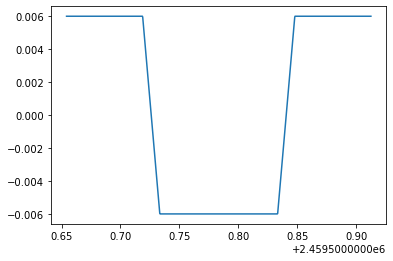

Contact 1 = 2459500.726108332
Contact 2 = 2459500.840691668
Contact 1 relative to center: -1.38 hours
Contact 2 relative to center: 1.38 hours
Total transit duration: 2.75 hours


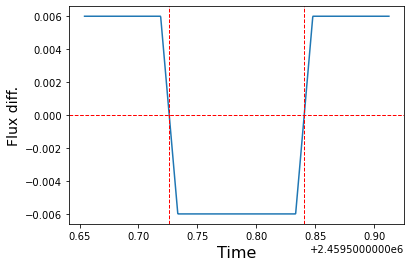

In [1]:
# Part A

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

hours2days = 1.0/24.0

t0 = 2459500.7834      # BJD (in days)
Ttot = 3.1*hours2days  # in days
Tflat = 2.4*hours2days # in days
Tstart = t0 - Ttot/2.
Tend = t0 + Ttot/2.
Tf1 = t0 - Tflat/2
Tf2 = t0 + Tflat/2
depth = 0.012
thresh = 0.994

def obsflux(t, depth, ftransit): return 1. - depth*ftransit(t)

def ftransit(t):  
    deltat = np.abs(t - t0)
    ft = 0.
    # The part below coul;d be implemented in a fancier way by using, e.g., 'piecewise'
    # Using ifs for clarity
    # Before ingress or after egress (no screening, "full flux")
    if (t < Tstart or t > Tend):
        ft = 0.
    # Between ingress and beginning of flat phase (partial screening, linear flux decrease))
    elif (t > Tstart and t < Tf1):
        ft = (t-Tstart)/((Ttot - Tflat)/2.)
    # Flat phase (maximum "screening" by the entire planet disk, constant flux at minimum)
    elif (t > Tf1 and t < Tf2):
        ft = 1.
    # Between end of flat phase and egress (planet exiting the star disk, linear increase in flux)
    elif (t > Tf2 and t < Tend):
        ft = (Tend - t)/((Ttot - Tflat)/2.)
    return ft

def fluxdiff(t, depth, ftransit): return obsflux(t, depth, ftransit) - thresh

# VECTORIZATION
fluxdiff_vec = np.vectorize(lambda t: fluxdiff(t, depth, ftransit))
# Another way to vectorize
#fluxdiff_vec = np.vectorize(fluxdiff, excluded=['depth', 'ftransit'])


# Safety check. Plot fluxdiff. 
times = np.linspace(t0-Ttot,t0+Ttot,1000)
#fld = [ ]

# Old ways
#for t in times:
#    fld.append(fluxdiff(t, depth, ftransit))
# Vectorization
fld = fluxdiff_vec(times)

plt.plot(times,fld)
plt.show()


# Root finding.
a = t0-Ttot
b = t0
root1 = opt.root_scalar(fluxdiff_vec, method='bisect', bracket=[a,b])
print('Contact 1 =', root1.root)


# Root finding.
a = t0
b = t0+Ttot
root2 = opt.root_scalar(fluxdiff_vec, method='bisect', bracket=[a,b])
print('Contact 2 =', root2.root)

print(f"Contact 1 relative to center: {(root1.root - t0)*24:.2f} hours")
print(f"Contact 2 relative to center: {(root2.root - t0)*24:.2f} hours")
print(f"Total transit duration: {(root2.root - root1.root)*24:.2f} hours")

# Graphic check
plt.plot(times,fld)
plt.xlabel('Time',size=16)
plt.ylabel('Flux diff.',size=14)
plt.axhline(linestyle='dashed',color = 'red',lw=1)
plt.axvline(x=root1.root,linestyle='dashed',color='red',lw=1)
plt.axvline(x=root2.root,linestyle='dashed',color='red',lw=1)
plt.show()

In [4]:
# Part B
dPdt = -2.9e-10
n = 500
residual = 0.5*dPdt*n**2
#print(residual, 'days')
print(f"Timing residual: {residual*24*3600:.2f} seconds")

Timing residual: -3.13 seconds


In [5]:
# Part C

# Contact point 1. Derivative: dF/dt =  - depth * (dg/dt)  where g = transit. 
# At contact 1: dg/dt = 1/[(Ttot-Tflat)/2]. 
# At contact 2: dg/dt = - 1/[(Ttot-Tflat)/2]
# When adding in quadrature the errors at the two contact point will be equal, as expected 
# from simmetry arguments.

# "Systematic" error from discrete time sample = 0.5 min
sigma_d = 0.5 # min
# Statistical error due to flux uncertainty sigma_photometric = sigma_time * |dF/dt|
days2minutes = 1440
dFdt_invminutes = np.abs(depth)/(days2minutes*(Ttot-Tflat)/2.)
sigma_photometric = 0.03/100.

sigma_t = sigma_photometric/dFdt_invminutes  # Make a dimension check. Dimension = [time] -> ok

sigma_total = np.sqrt(sigma_t**2 + sigma_d**2) 

print(f"Photometric timing error: {sigma_t:.2f} minutes")
print(f"Discretization error: {sigma_d:.2f} minutes") 
print(f"Total timing uncertainty: {sigma_total:.2f} minutes")

Photometric timing error: 0.52 minutes
Discretization error: 0.50 minutes
Total timing uncertainty: 0.72 minutes


## Exercise 2: Axion Field Evolution

The axion field φ(t) evolves according to the equation of motion:

$$\ddot{\phi} + 3H(t)\dot{\phi} + m_a^2(t) \sin(\phi) = 0$$

where H(t) is the Hubble parameter, m_a(t) is the time-dependent axion mass, and all quantities are dimensionless.

The time-dependent functions are given by:

- **Hubble parameter:** 
  - H(t) = H_0(t_{eq}/t) for t < t_eq
  - H(t) = H_0(t_{eq}/t)^{2/3} for t ≥ t_eq

- **Axion mass:** 
  - m_a(t) = m_{a,0}(t/t_{eq})^{1.75} for t < t_eq
  - m_a(t) = m_{a,0}(t/t_{eq})^{1.17} for t ≥ t_eq

**Dimensionless parameters:**
- f_a = 1.0 (normalized axion decay constant)
- m_{a,0} = 1.0 (normalized present-day axion mass)
- H_0 = 1.0 (normalized Hubble parameter)
- t_eq = 1.0 (matter-radiation equality time)

---

### Question 1: Numerical Setup

**a)** Implement the functions H(t) and m_a(t) according to the expressions above.

**b)** Set up the ODE system for numerical integration using `scipy.integrate.odeint` or any other integrator of your choice.

---

### Question 2: Numerical Solution and Plotting

Solve the system numerically over the time interval 0.01 < t < 100 for **two initial conditions:**
- Case A: φ_0 = 0.5, φ̇_0 = 0
- Case B: φ_0 = 2.0, φ̇_0 = 0

Create a plot showing φ(t) as a function of time for both cases on the same graph. Use a logarithmic time axis and mark the transition time t_eq = 1.0 with a vertical dashed line.

---

**Technical requirements:**
- Use at least 2000 time points for smooth curves
- Include proper axis labels, legends, and units
- Handle the transition at t_eq correctly in your H(t) and m_a(t) functions

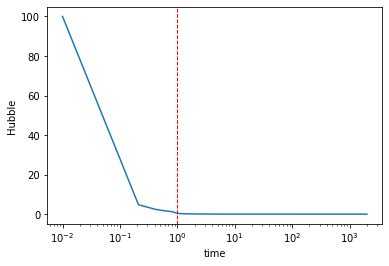

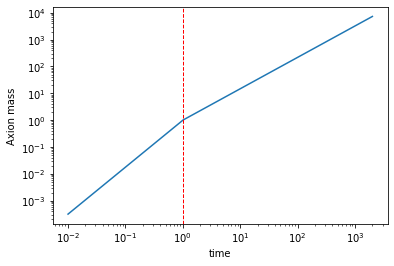

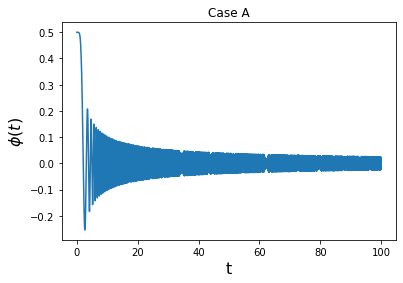

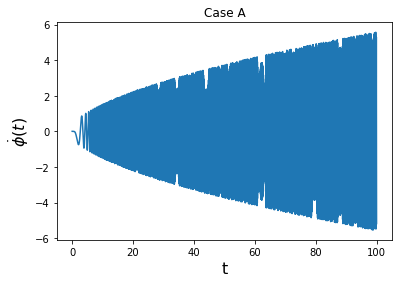

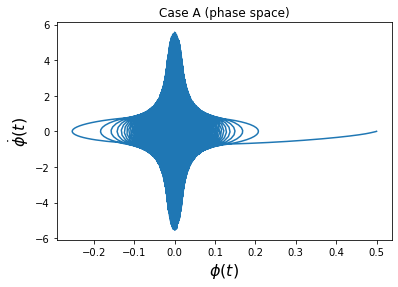

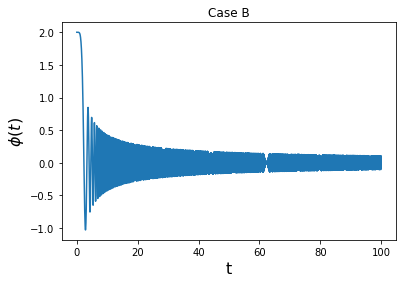

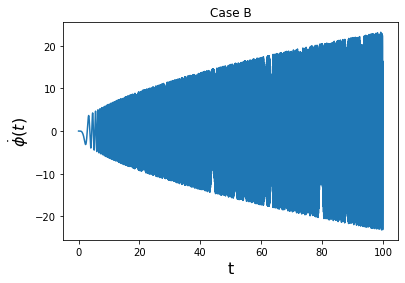

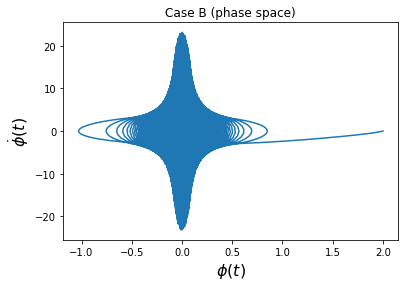

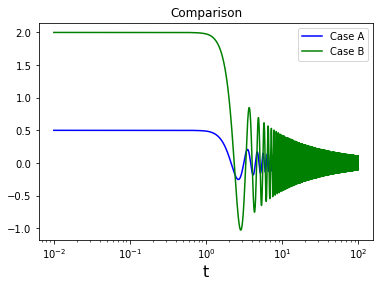

In [7]:
# Question 1

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import integrate

# Parameters
fa = 1.0
ma0 = 1.0
H0 = 1.0
teq = 1.0


# Hubble
#############################
def Hubble(t, teq):
    H = np.piecewise(t, [t < teq, t >= teq], [lambda t: H0*(teq/t), lambda t: H0*(teq/t)**2/3])
    
    # Traditional alternative
    #if t < teq:
    #    return H0 * (teq/t)           # radiation era
    #else:
    #    return H0 * (teq/t)**(2/3)   # matter era
    
    return H

# Vectorizing Hubble
Hubble_vec = np.vectorize(lambda t: Hubble(t,teq))
                     
# Testing Hubble.
times = np.linspace(0.01,2000,10000)
Hlist = Hubble_vec(times)

plt.plot(times,Hlist)
plt.xlabel('time')
plt.ylabel('Hubble')
plt.axvline(x=teq,linestyle='dashed',color='red',lw=1)
plt.xscale('log')
plt.show()

# Axion mass
################################
def axion_mass(t, teq):
    am = np.piecewise(t, [t < teq, t >= teq], [lambda t: ma0*(t/teq)**1.75, lambda t: ma0*(t/teq)**1.17])
    return am

# Vectorizing axion_mass
axion_mass_vec = np.vectorize(lambda t: axion_mass(t,teq))

# Testing axion mass.
times = np.linspace(0.01,2000,10000)
alist = axion_mass_vec(times)

plt.plot(times,alist)
plt.xlabel('time')
plt.ylabel('Axion mass')
plt.axvline(x=teq,linestyle='dashed',color='red',lw=1)
plt.xscale('log')
plt.yscale('log')
plt.show()

# ODE
#####################################
# Derivatives
def f(x,t):
    # psi= d phi/dt, d psi/ dt = -3H psi - m^2sin(phi), x = [phi,psi]
    H = Hubble(t,teq)
    ma = axion_mass(t,teq)
    phi = x[0]
    psi = x[1]
    dphidt = psi
    dpsidt = -3.*H*psi - ma**2*np.sin(phi)
    return np.array([dphidt,dpsidt], dtype = 'float')


# Question 2

# Initial conditions, case A.
y0 = [0.5,0.]
plt.title('Case A')
t = np.linspace(0.01,100.0,4000)
y = sp.integrate.odeint(f,y0,t)
plt.xlabel('t',size=16)
plt.ylabel('$\phi(t)$',size=16)
plt.plot(t,y[:,0])
plt.show()
plt.title('Case A')
plt.xlabel('t',size=16)
plt.ylabel('$\dot{\phi}(t)$',size=16)
plt.plot(t,y[:,1])
plt.show()
plt.title('Case A (phase space)')
plt.xlabel('$\phi(t)$',size=16)
plt.ylabel('$\dot{\phi}(t)$',size=16)
plt.plot(y[:,0],y[:,1])
plt.show()

# Initial conditions, case B.
y0 = [2.,0.]
plt.title('Case B')
t = np.linspace(0.01,100.0,4000)
y1 = sp.integrate.odeint(f,y0,t)
plt.xlabel('t',size=16)
plt.ylabel('$\phi(t)$',size=16)
plt.plot(t,y1[:,0])
plt.show()
plt.title('Case B')
plt.xlabel('t',size=16)
plt.ylabel('$\dot{\phi}(t)$',size=16)
plt.plot(t,y1[:,1])
plt.show()
plt.title('Case B (phase space)')
plt.xlabel('$\phi(t)$',size=16)
plt.ylabel('$\dot{\phi}(t)$',size=16)
plt.plot(y1[:,0],y1[:,1])
plt.show()

# Comparison
plt.title('Comparison')
plt.xlabel('t',size=16)
plt.xscale('log')
plt.plot(t,y[:,0],color = 'blue',label='Case A')
plt.plot(t,y1[:,0],color='green',label= 'Case B')
plt.legend()
plt.show()